In [2]:
import pandas as pd
import numpy as np
import glob
import gc
import matplotlib.pyplot as plt
from matplotlib import colors
from astropy.coordinates import SkyCoord, AltAz, angular_separation
import astropy.units as u
from scipy.stats import binned_statistic
from scipy.signal import lombscargle
import h5py
from astropy.io import fits
from astropy.table import Table
from tables import open_file
from astropy.table import join, vstack
from astropy.stats import sigma_clip
from ctapipe.io import read_table 
from ctapipe.instrument import SubarrayDescription
from matplotlib.colors import LogNorm
import math
import yaml
from iminuit import Minuit

In [2]:
conf = {'file': './data/muon-_0deg_0deg_run000008___cta-prod6-2156m-LaPalma-lst-dark-ref-degraded-0.83.h5',
        'throughputconf': './throughput_muon_configuration.yaml',
        'min': 0.1,
        'max': 0.3,
        'nbins': 100,
        'if_fit': True,
       }

#fit_conf = {'gauss_a_ampl': 700,
#            'gauss_a_x0': 0.175,
#            'gauss_a_sig': 0.01,
#            'gauss_a_if_fix': False,
#            'gauss_b_ampl': 30,
#            'gauss_b_x0': 0.175,
#            'gauss_b_sig': 0.1,
#            'gauss_b_if_fix': False,
#            'pedestal': 0.0,
#       }

In [61]:
def print_conf_to_pdf(conf):
    fig=plt.figure(figsize=(15, 5))  # 10 inches wide, 6 inches tall
    plt.axis('off')
    y_pos = 1.0
    y_step = 0.1
    for key, values in conf.items():
        plt.text(0, y_pos, f"{key}: {values}", fontsize=12, va='top')
        y_pos -= y_step

    return fig

In [3]:
def get_hist_stat(hist_tmp):
    counts = hist_tmp[0]
    bin_edges = hist_tmp[1]
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Weighted standard deviation
    if(np.sum(counts) > 0):
        mean = np.average(bin_centers, weights=counts)
        variance = np.average((bin_centers - mean)**2, weights=counts)
        std = np.sqrt(variance)
    else:
        mean = 0
        variance = 0
        std = 0
    
    print("mean     = ",mean)
    #print("variance = ",variance)
    print("std      = ",std)
    print("sum      = ",np.sum(counts))

In [4]:
def get_fit_conf():
    fit_conf = {'gauss_a_if_fix': False,
                'gauss_a_ampl': 500,
                'gauss_a_x0': 0.175,
                'gauss_a_sig': 0.01,
                'gauss_b_if_fix': False,
                'gauss_b_ampl': 200,
                'gauss_b_x0': 0.18,
                'gauss_b_sig': 0.02,
                'gauss_c_if_fix': False,
                'gauss_c_ampl': 30,
                'gauss_c_x0': 0.15,
                'gauss_c_sig': 0.007,
                'pedestal': 0.0,
               }
    return fit_conf

In [5]:
def gauss_pedestal(x, A, mu, sigma, pedestal = 0.0):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2) + pedestal

In [6]:
def fit_function(x, A1, mu1, sigma1, A2, mu2, sigma2, A3, mu3, sigma3, pedestal):
    return ( gauss_pedestal(x, A1, mu1, sigma1, pedestal) + 
             gauss_pedestal(x, A2, mu2, sigma2) +
             gauss_pedestal(x, A3, mu3, sigma3)
           )

In [7]:
def fit_function_from_conf(conf, x):
    return fit_function(x, 
                        conf['gauss_a_ampl'], 
                        conf['gauss_a_x0'], 
                        conf['gauss_a_sig'],
                        conf['gauss_b_ampl'], 
                        conf['gauss_b_x0'], 
                        conf['gauss_b_sig'],
                        conf['gauss_c_ampl'], 
                        conf['gauss_c_x0'], 
                        conf['gauss_c_sig'],
                        conf['pedestal'])

In [8]:
def fit_optical_throughput(optical_throughput_x, optical_throughput_y, fit_conf):
    #
    # minimization method
    #
    fit = Minuit(
        loss(optical_throughput_x, optical_throughput_y),
        A1=fit_conf['gauss_a_ampl'],
        mu1=fit_conf['gauss_a_x0'],
        sigma1=fit_conf['gauss_a_sig'],
        A2=fit_conf['gauss_b_ampl'],
        mu2=fit_conf['gauss_b_x0'],
        sigma2=fit_conf['gauss_b_sig'],
        A3=fit_conf['gauss_c_ampl'],
        mu3=fit_conf['gauss_c_x0'],
        sigma3=fit_conf['gauss_c_sig'],
        pedestal= fit_conf['pedestal'],
    )
    fit.errordef = Minuit.LEAST_SQUARES
    #
    fit.errors["A1"] = 0.01
    fit.errors["mu1"] = 0.1
    fit.errors["sigma1"] = 0.1
    if (fit_conf['gauss_a_if_fix']):
        fit.fixed["A1"] = True
        fit.fixed["mu1"] = True
        fit.fixed["sigma1"] = True
    #
    fit.errors["A2"] = 0.01
    fit.errors["mu2"] = 0.1
    fit.errors["sigma2"] = 0.1
    if (fit_conf['gauss_b_if_fix']):
        fit.fixed["A2"] = True
        fit.fixed["mu2"] = True
        fit.fixed["sigma2"] = True
    #
    fit.errors["A3"] = 0.01
    fit.errors["mu3"] = 0.1
    fit.errors["sigma3"] = 0.1
    if (fit_conf['gauss_c_if_fix']):
        fit.fixed["A3"] = True
        fit.fixed["mu3"] = True
        fit.fixed["sigma3"] = True
    #
    fit.errors["pedestal"] = 0.001
    #
    fit.migrad()
    #
    fit_conf_out = get_fit_conf()
    #
    fit_conf_out['gauss_a_ampl'] = fit.values["A1"]
    fit_conf_out['gauss_a_x0'] = fit.values["mu1"]
    fit_conf_out['gauss_a_sig'] = fit.values["sigma1"]
    fit_conf_out['gauss_b_ampl'] = fit.values["A2"]
    fit_conf_out['gauss_b_x0'] = fit.values["mu2"]
    fit_conf_out['gauss_b_sig'] = fit.values["sigma2"]
    fit_conf_out['gauss_c_ampl'] = fit.values["A3"]
    fit_conf_out['gauss_c_x0'] = fit.values["mu3"]
    fit_conf_out['gauss_c_sig'] = fit.values["sigma3"]
    fit_conf_out['pedestal'] = fit.values["pedestal"]
    #
    return fit_conf_out

In [9]:
def loss(x, y):
    def loss_function(A1, mu1, sigma1, A2, mu2, sigma2, A3, mu3, sigma3, pedestal):
        diff_squared = (fit_function(x, 
                                     A1, mu1, sigma1, 
                                     A2, mu2, sigma2, 
                                     A3, mu3, sigma3, 
                                     pedestal) - y) ** 2
        return diff_squared.sum()
    return loss_function

In [59]:
#data
h5file=open_file(conf['file'], "a")
df = pd.DataFrame(h5file.root.dl1.event.telescope.muon.tel_001[:])
optical_throughput =df['muonefficiency_optical_efficiency'].values
optical_throughput = optical_throughput[~np.isnan(optical_throughput)]

#throughputconf
with open(conf['throughputconf'], 'r') as file:
    throughputconf = yaml.safe_load(file)

chunk_size = throughputconf['CalculateThroughputWithMuons']['chunk_size']
max_sigma  = throughputconf['CalculateThroughputWithMuons']['SigmaClippingAggregator']['max_sigma']
iterations = throughputconf['CalculateThroughputWithMuons']['SigmaClippingAggregator']['iterations']


throughputconf_pdf = {'chunk_size': chunk_size,
        'max_sigma': max_sigma,
        'iterations': iterations,
       }

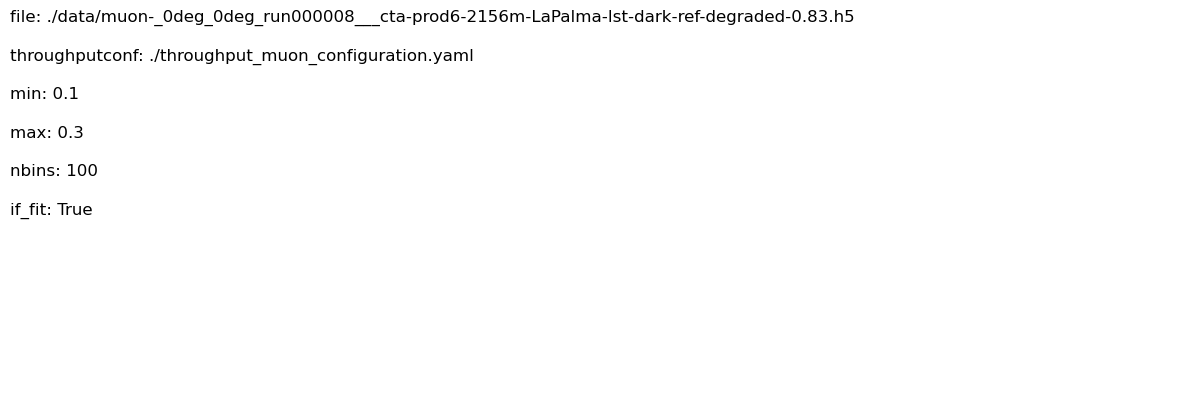

In [62]:
fig=print_conf_to_pdf(conf)

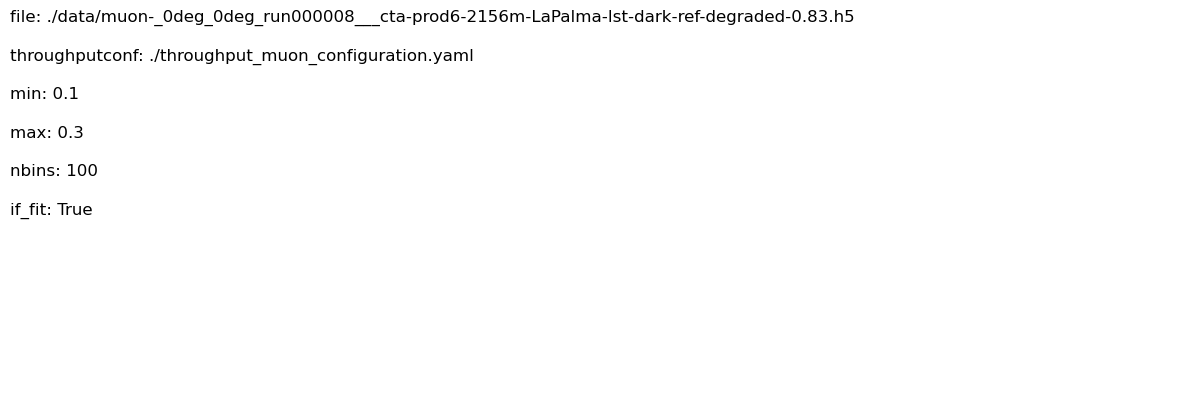

In [63]:
fig

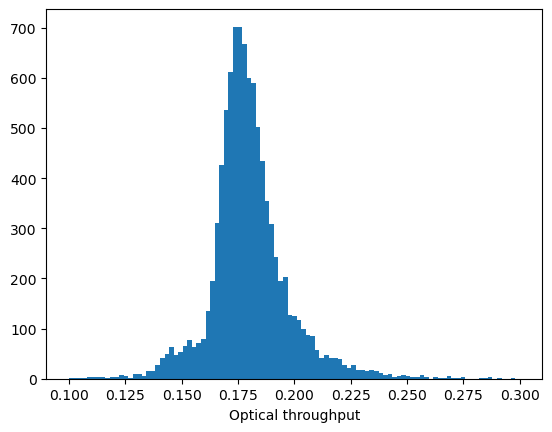

In [11]:
hist_optical_throughput = plt.hist(optical_throughput, 
                                   bins=np.linspace(conf['min'],
                                                    conf['max'],
                                                    conf['nbins']))
plt.xlabel('Optical throughput')
plt.show()

In [12]:
optical_throughput_y = hist_optical_throughput[0]
optical_throughput_x = ((np.roll(hist_optical_throughput[1], 1) + hist_optical_throughput[1]) / 2.0)[1:]

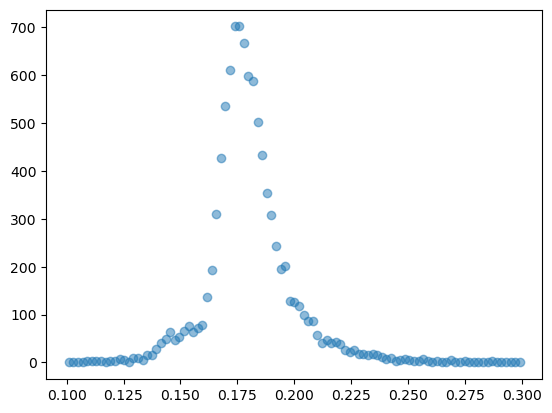

In [13]:
plt.scatter(optical_throughput_x,
            optical_throughput_y,
            alpha=0.5)
#plt.xlabel('X axis')
#plt.ylabel('Y axis')
#plt.ylim(1,8)
#plt.title('Scatter Plot Example')
plt.show()

In [14]:
np.mean(optical_throughput)

np.float64(0.1841600680230464)

In [15]:
filtered_data = sigma_clip(
            optical_throughput,
            sigma=max_sigma,
            maxiters=iterations,
            cenfunc="mean",axis=0)
element_mean = np.ma.mean(filtered_data, axis=0)
print(element_mean)

0.17892386497963506


In [16]:
fit_conf = fit_optical_throughput(optical_throughput_x, optical_throughput_y, get_fit_conf())
print(fit_conf)

{'gauss_a_if_fix': False, 'gauss_a_ampl': 360.6710660523071, 'gauss_a_x0': 0.17244786506043322, 'gauss_a_sig': 0.005159160493837667, 'gauss_b_if_fix': False, 'gauss_b_ampl': 349.6281788743641, 'gauss_b_x0': 0.18112101216851156, 'gauss_b_sig': 0.0072182809134760375, 'gauss_c_if_fix': False, 'gauss_c_ampl': 142.89790842072432, 'gauss_c_x0': 0.18257929624317568, 'gauss_c_sig': 0.022462916908186827, 'pedestal': 1.8326290208634852}


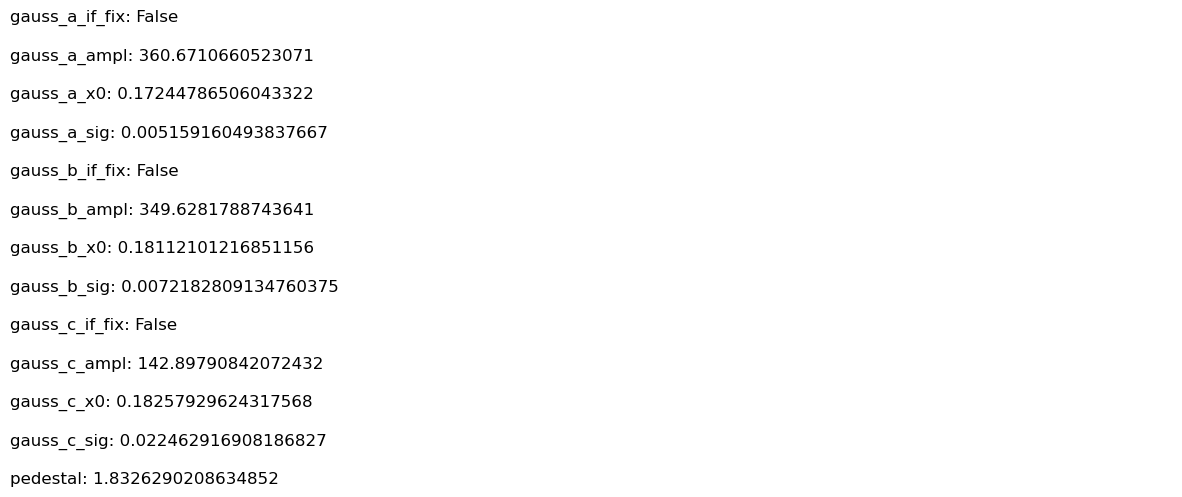

In [56]:
print_conf_to_pdf(fit_conf)

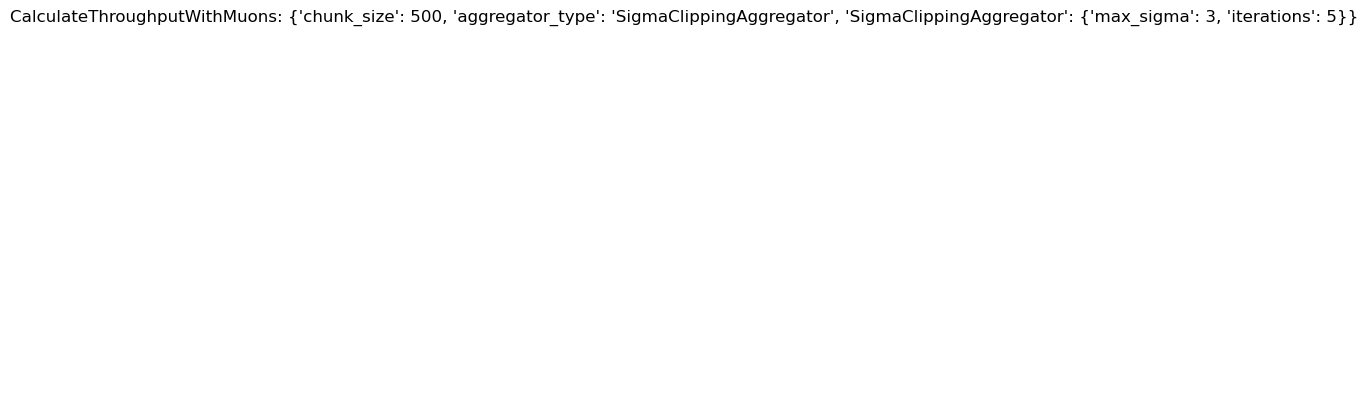

In [57]:
print_conf_to_pdf(throughputconf)

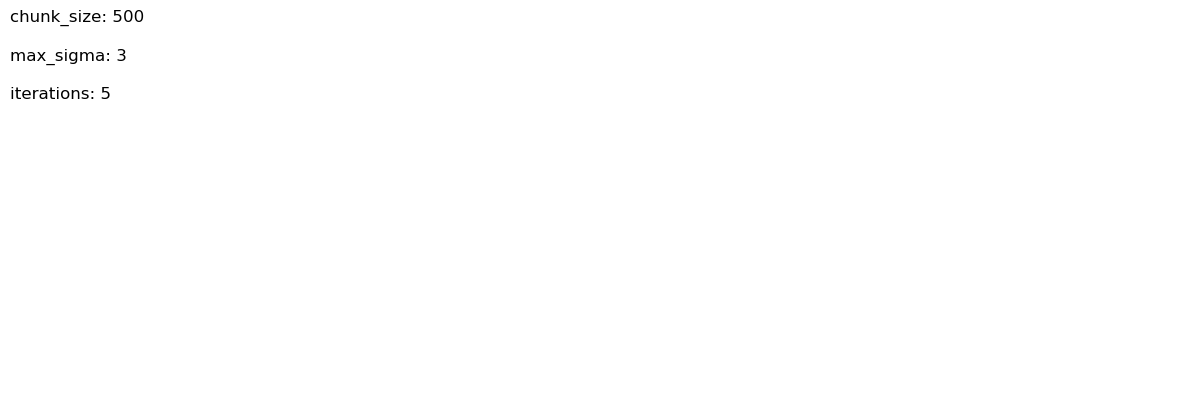

In [60]:
print_conf_to_pdf(throughputconf_pdf)

In [17]:
x_fit = np.linspace(conf['min'],conf['max'], conf['nbins'])
y_initial = fit_function_from_conf(get_fit_conf(), x_fit)
y_fit = fit_function_from_conf(fit_conf, x_fit)

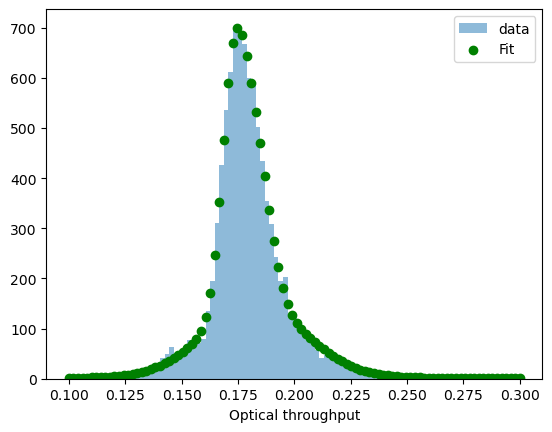

In [25]:
hist_optical_throughput = plt.hist(optical_throughput, 
                                   bins=np.linspace(conf['min'],
                                                    conf['max'],
                                                    conf['nbins']),
                                   alpha=0.5,
                                   label='data'
                                  )
#plt.scatter(optical_throughput_x,
#            optical_throughput_y,
#            alpha=1.0)
#plt.scatter(x_fit,
#            y_initial,
#            alpha=1.0)
plt.scatter(x_fit,
            y_fit,
            alpha=1.0,
            c='g',
            label='Fit',
           )
#plt.xlabel('X axis')
#plt.ylabel('Y axis')
#plt.ylim(1,8)
#plt.title('Scatter Plot Example')
plt.legend()
plt.xlabel('Optical throughput')
plt.show()

In [3]:
np.linspace(0,10,10)

array([ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
        5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ])

In [4]:
10/9.0

1.1111111111111112